# NSF Computer and Information Science and Engineering (CISE) 

- `05050000`: Division of Computer and Network Systems (CNS)
- `05010000`: Division of Computing and Communication Foundations (CCF)
- `05020000`: Division of Information and Intelligent Systems (IIS)
- `05090000`: Office of Advanced Cyberinfrastructure (OAC)

In [1]:
import os,sys,json
import core.coworknet, core.nsf_utils
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import networkx as nx
from datetime import datetime
from collections import Counter

In [2]:
grant_type = ["Standard Grant", "Continuing grant"] # draw only these types
div_type = {
    "05050000": "Division of Computer and Network Systems (CNS)",
    "05010000": "Division of Computing and Communication Foundations (CCF)",
    "05020000": "Division of Information and Intelligent Systems (IIS)",
    "05090000": "Office of Advanced Cyberinfrastructure (OAC)"
}

In [3]:
def histogram_num_pis(data, years, orgcodes):
    plt.title("[NSF {}-{}] histogram - number of PIs".format(years[0], years[-1]))
    plt.ylabel("Number of grants")
    plt.xlabel("Number of PIs")
    pis = [d["num_pis"] for d in data.values() if d["org"] in orgcodes]
    counter_pis = Counter(pis)
    print(counter_pis)
    x = range(1, 10)
    y = [counter_pis[i] if i in counter_pis else 0 for i in x]
    plt.bar(x, y)

In [4]:
data = {}
years = [2004]
for y in years:
    data.update(core.nsf_utils.load_numpub_data(y))
data = {k:v for k, v in data.items() if v["type"] in grant_type}
for y in years:
    print("[{}]".format(y))
    print("Total number of grants", len([v for v in data.values() if v["year"] == y]))
    for code, desc in div_type.items():
        print(desc, len([v for v in data.values() if v["org"] == code and v["year"] == y]))

[2004]
Total number of grants 10212
Division of Computer and Network Systems (CNS) 405
Division of Computing and Communication Foundations (CCF) 332
Division of Information and Intelligent Systems (IIS) 362
Office of Advanced Cyberinfrastructure (OAC) 53


Counter({1: 633, 2: 243, 3: 123, 5: 83, 4: 61, 6: 4, 0: 2, 7: 2, 8: 1})


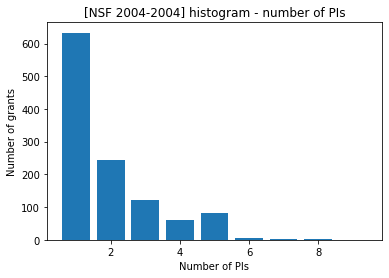

In [5]:
histogram_num_pis(data, years, div_type.keys())

In [6]:
grant_list = [k for k, d in data.items() if d["org"] in div_type.keys() and d["num_pis"] == 5]
print(grant_list)

['0403313', '0403340', '0403342', '0403428', '0403673', '0403760', '0403990', '0404208', '0406403', '0416128', '0420477', '0420614', '0420703', '0420793', '0420836', '0420933', '0420984', '0421063', '0421099', '0421109', '0421200', '0421282', '0421456', '0421502', '0421554', '0423336', '0423386', '0423431', '0423733', '0423891', '0424546', '0426125', '0426593', '0426683', '0426886', '0426971', '0426972', '0427005', '0427413', '0427794', '0428168', '0428216', '0428241', '0428249', '0428344', '0428404', '0428420', '0428472', '0428738', '0428856', '0428887', '0429086', '0429358', '0430175', '0430274', '0430444', '0430722', '0431070', '0432047', '0433540', '0433702', '0435061', '0435190', '0435297', '0435307', '0435353', '0435370', '0435389', '0435425', '0442156', '0444465', '0451843', '0453809', '0454066', '0454074', '0454114', '0454259', '0454279', '0454298', '0454333', '0454394', '0454404', '0454407']


In [86]:
no_publications = []
def plot_coauthor_heatmap(pid):
    table, ts, te, G = core.coworknet.get_grant_coworknet_pis(pid)
#     print(sorted(G.degree, key=lambda x: x[1], reverse=True))
    authors = list([a[0] for a in sorted(G.degree, key=lambda x: x[1], reverse=True)])

    # # calculate coauthorship by papar
    # times = sorted([v["date"] for v in table.values()])
    # dates = {v["date"]:v["authors"] for v in table.values()}
    # coauthored = np.array([[1 if a in dates[t] else 0 for t in times] for a in authors])
    if len(table) == 0:
#         print("No publication between PIs")
        no_publications.append(pid)
        return
    
    # calculate coauthorship by year
    times = range(min([v["year"] for v in table.values()]), 1+max([v["year"] for v in table.values()]))
    years = [datetime.strptime(str(t), "%Y") for t in times]
    dates = {y:[] for y in times}
    for v in table.values():
        dates[v["year"]].extend(v["authors"])
    dates_ingrant = {y:[] for y in times}
    for v in table.values():
        if v["type"]:
            dates_ingrant[v["year"]].extend(v["authors"])
    coauthored_ingrant = np.array([[dates_ingrant[t].count(a) for t in times] for a in authors])
    coauthored = np.array([[dates[t].count(a) for t in times] for a in authors])
    
    fig, ax = plt.subplots(figsize=(len(times)/2,len(authors)/2))
    im = ax.imshow(coauthored, cmap="YlGn")

    ax.set_xticks(np.arange(len(years)))
    ax.set_yticks(np.arange(len(authors)))
    # ax.set_xticklabels([datetime.strftime(t, "%Y-%m-%d") for t in times])
    ax.set_xticklabels(times)
    ax.set_yticklabels(authors)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    for i in range(len(authors)):
        for j in range(len(years)):
            label = str(coauthored[i, j] if coauthored[i, j] > 0 else "")
            if coauthored_ingrant[i, j] > 0:
                label = str(coauthored_ingrant[i, j]) + "/" + label
            if ts <= years[j] and years[j] <= te:
                text = ax.text(j, i, label, ha="center", va="center", color="black", fontweight="bold")
            else:
                text = ax.text(j, i, label, ha="center", va="center", color="black")

    ax.set_title("{} ({}~{})".format(pid, datetime.strftime(ts, "%Y-%m-%d"), datetime.strftime(te, "%Y-%m-%d")))
    plt.show()

def plot_coauthor_heatmap_paper(pid):
    table, ts, te, G = core.coworknet.get_grant_coworknet_pis(pid)
    authors = list([a[0] for a in sorted(G.degree, key=lambda x: x[1], reverse=True)])

    if len(table) == 0:
        no_publications.append(pid)
        return
    
    # calculate coauthorship by papar
    times = sorted([v["date"] for v in table.values()])
    dates = {v["date"]:v["authors"] for v in table.values()}
    dates_ingrant = [v["date"] for v in table.values() if v["type"]]
    coauthored = np.array([[2 if ts <= t and t <= te and a in dates[t] else (1 if a in dates[t] else 0) for t in times] for a in authors])
    coauthored_ingrant = np.array([[1 if t in dates_ingrant and a in dates[t] else 0 for t in times] for a in authors])
    
    fig, ax = plt.subplots(figsize=(len(times)/5,len(authors)/2))
    im = ax.imshow(coauthored, cmap="GnBu")

    ax.set_xticks(np.arange(len(times)))
    ax.set_yticks(np.arange(len(authors)))
    ax.set_xticklabels([datetime.strftime(t, "%Y-%m-%d") for t in times])
    ax.set_yticklabels(authors)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    for i in range(len(authors)):
        for j in range(len(times)):
            label = "*" if coauthored_ingrant[i, j] > 0 else ""
            text = ax.text(j, i, label, ha="center", va="center", color="black")

    ax.set_title("{} ({}~{})".format(pid, datetime.strftime(ts, "%Y-%m-%d"), datetime.strftime(te, "%Y-%m-%d")))
    plt.show()

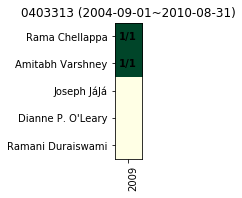

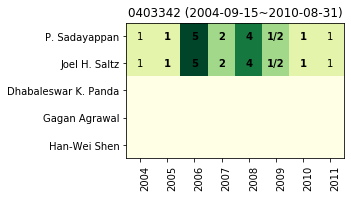

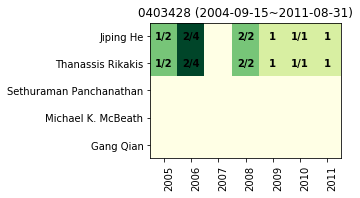

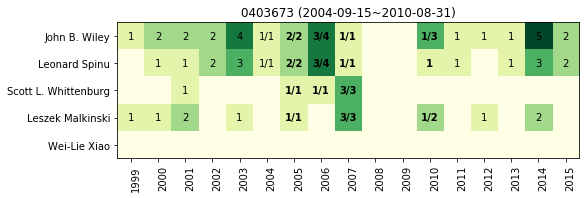

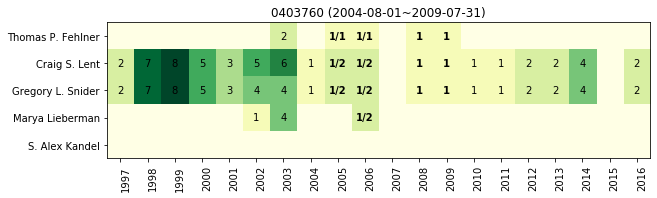

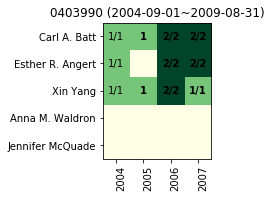

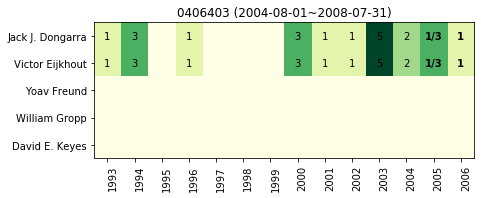

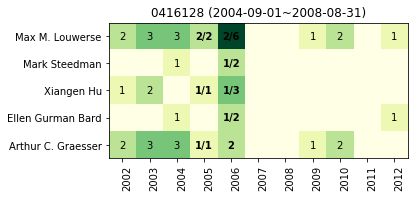

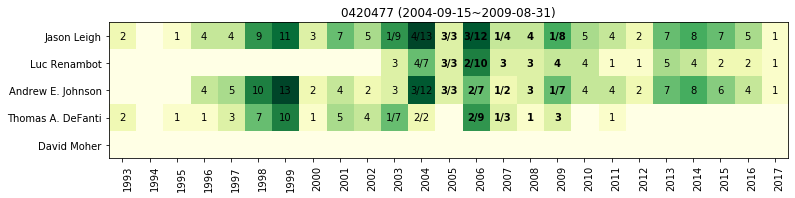

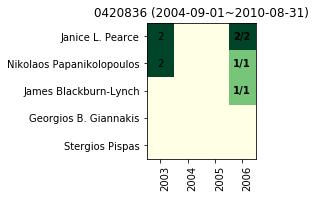

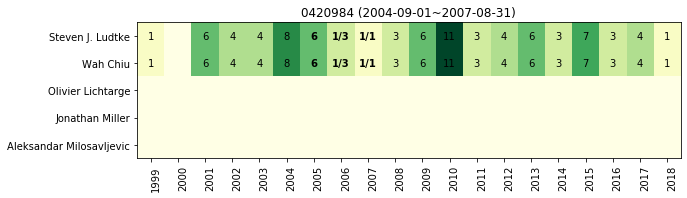

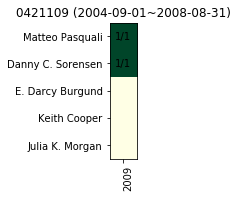

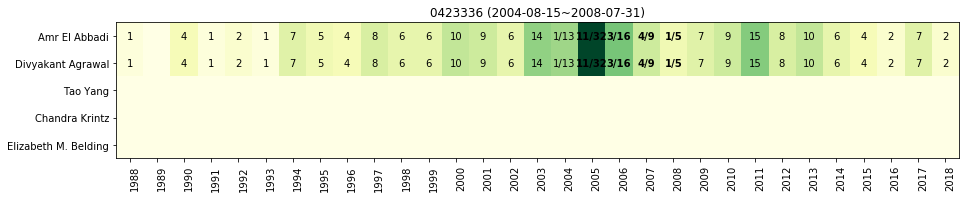

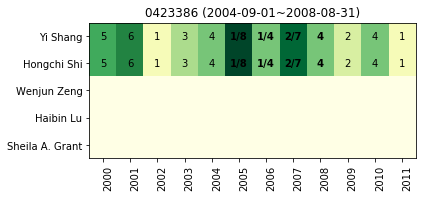

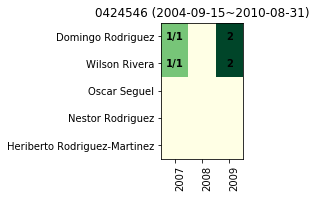

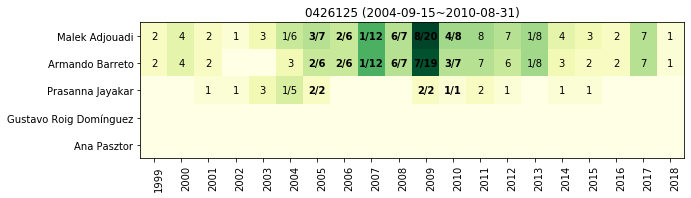

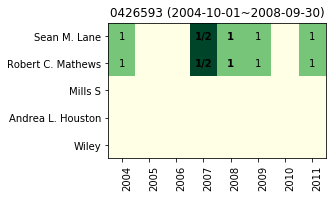

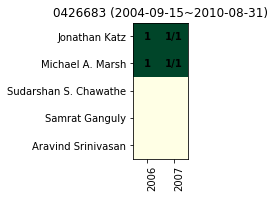

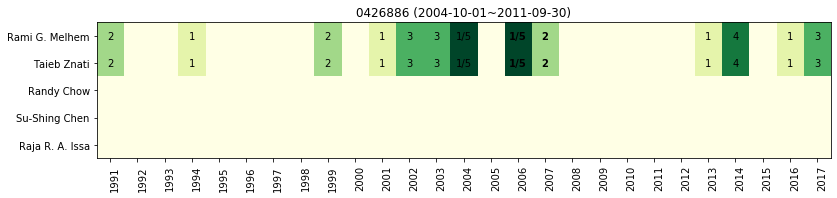

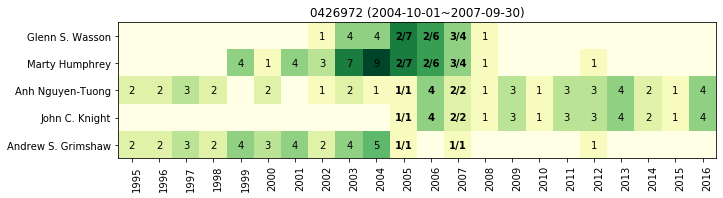

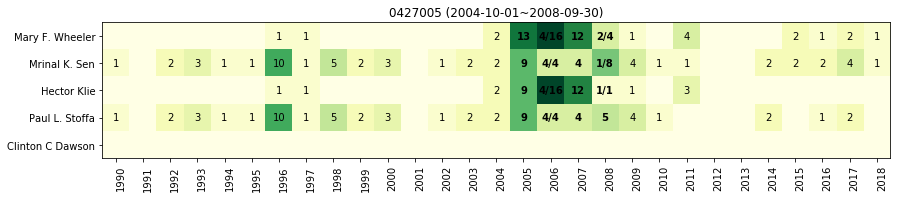

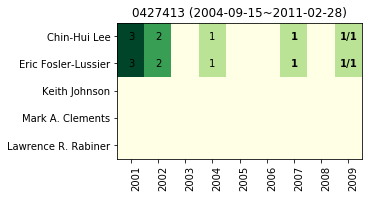

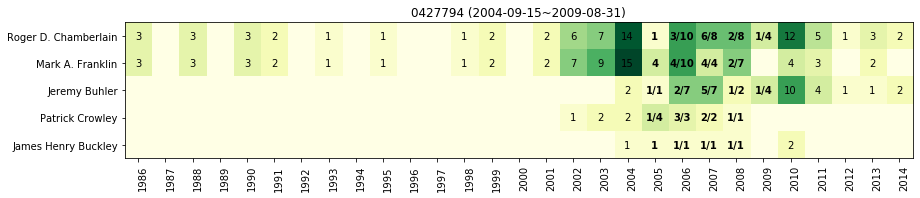

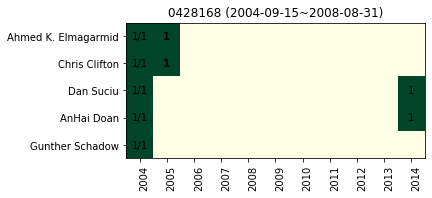

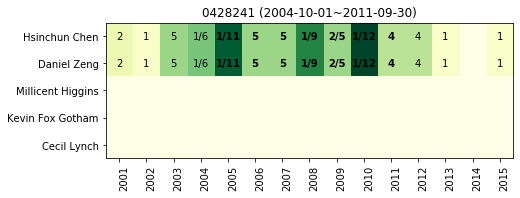

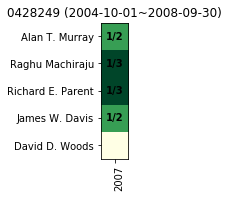

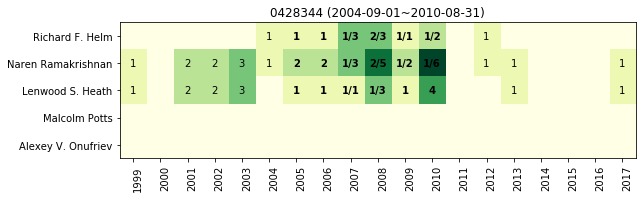

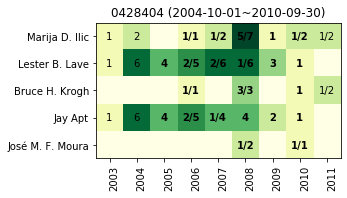

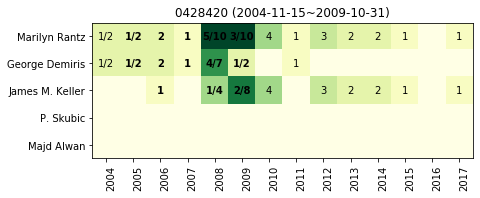

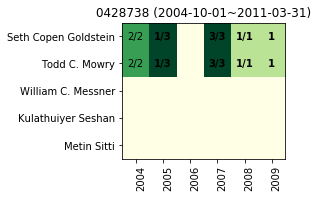

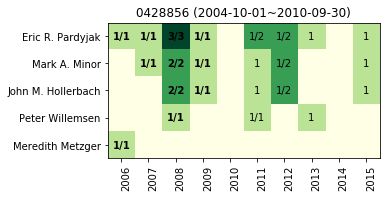

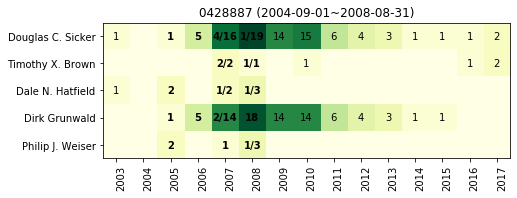

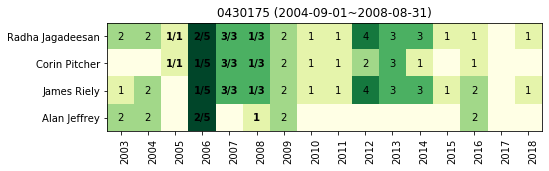

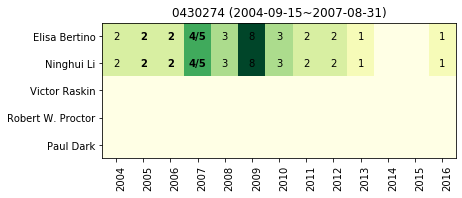

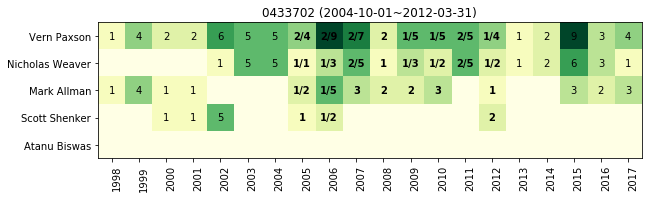

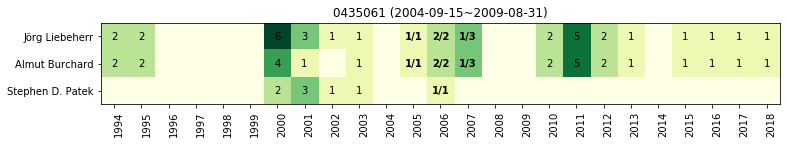

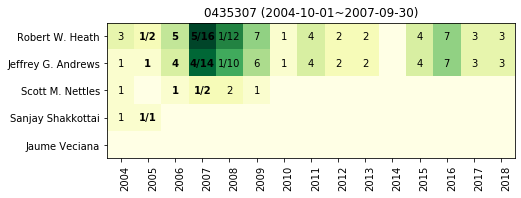

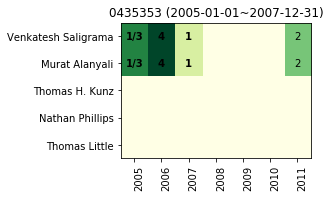

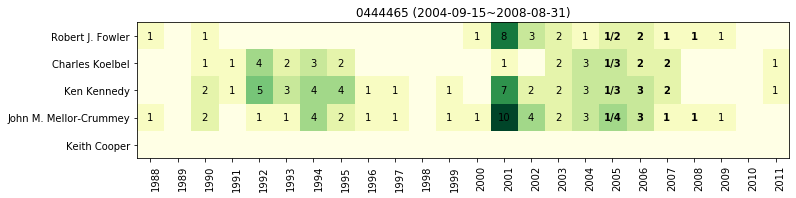

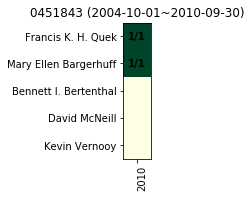

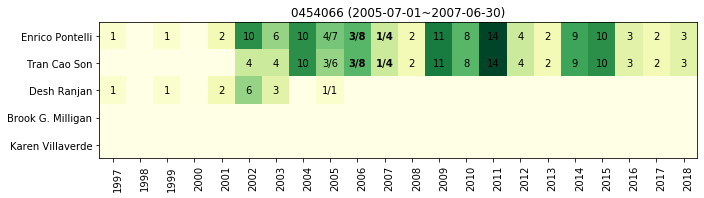

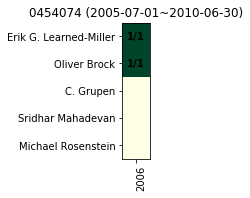

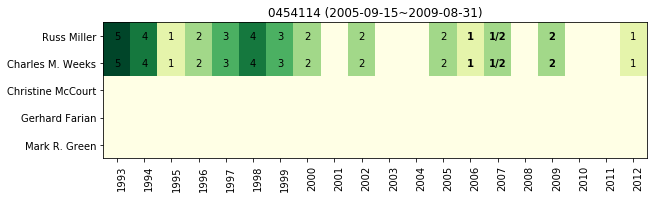

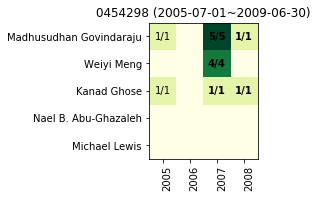

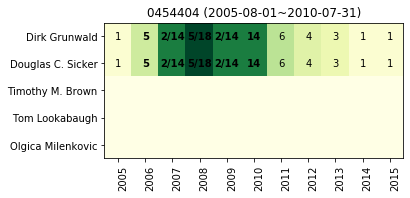

38 grants have no publication between PIs ['0403340', '0404208', '0420614', '0420703', '0420793', '0420933', '0421063', '0421099', '0421200', '0421282', '0421456', '0421502', '0421554', '0423431', '0423733', '0423891', '0426971', '0428216', '0428472', '0429086', '0429358', '0430444', '0430722', '0431070', '0432047', '0433540', '0435190', '0435297', '0435370', '0435389', '0435425', '0442156', '0453809', '0454259', '0454279', '0454333', '0454394', '0454407']


In [66]:
for pid in grant_list:
    plot_coauthor_heatmap(pid)
print("{} grants have no publication between PIs".format(len(no_publications)), no_publications)

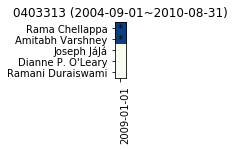

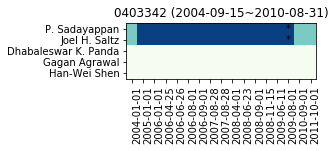

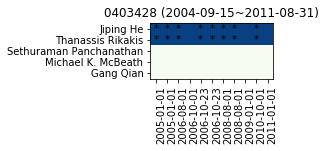

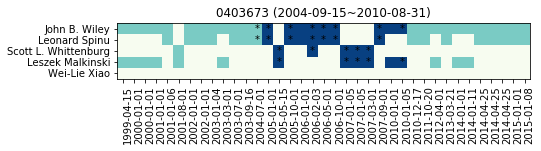

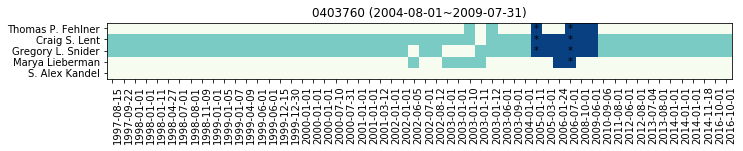

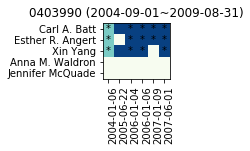

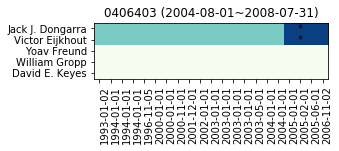

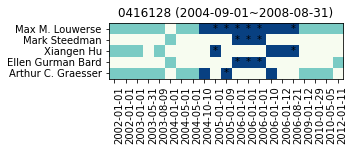

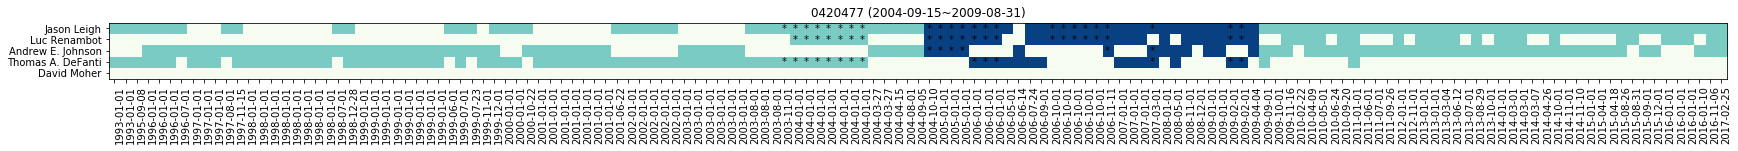

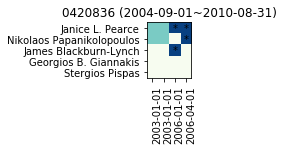

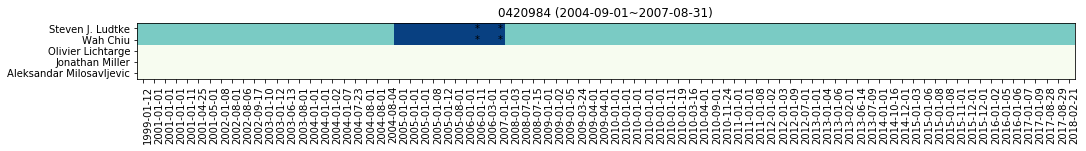

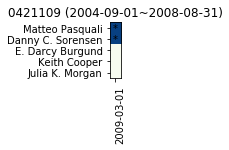

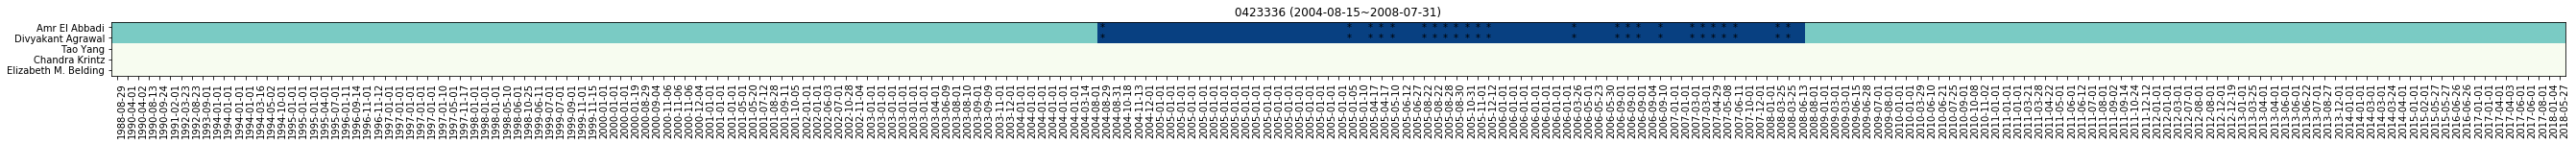

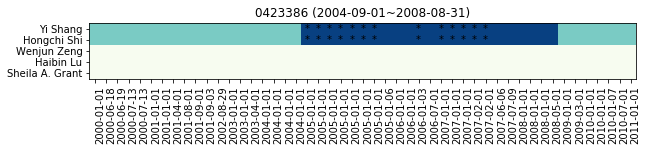

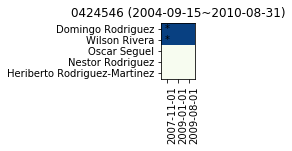

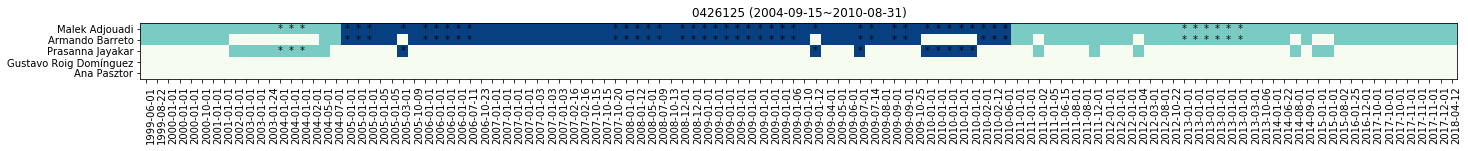

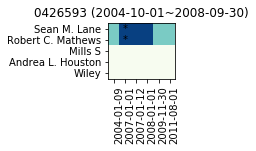

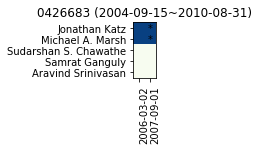

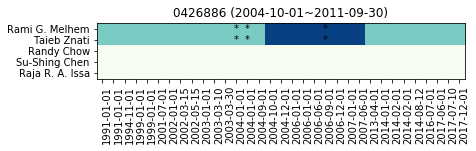

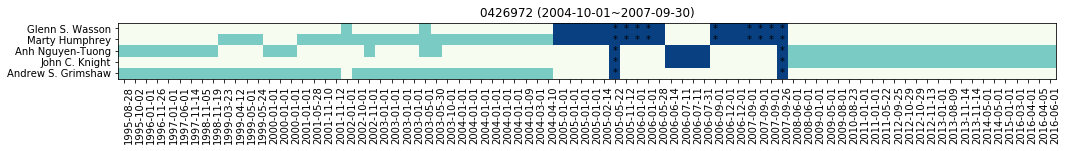

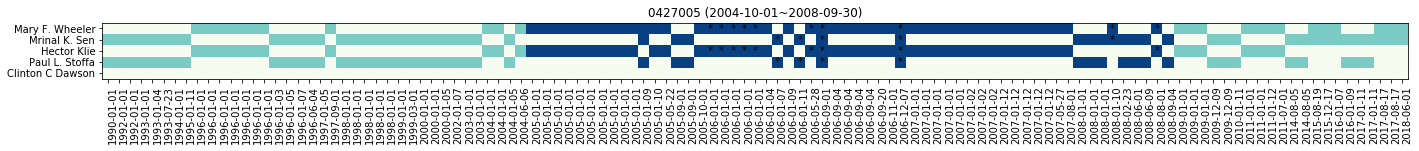

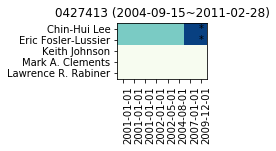

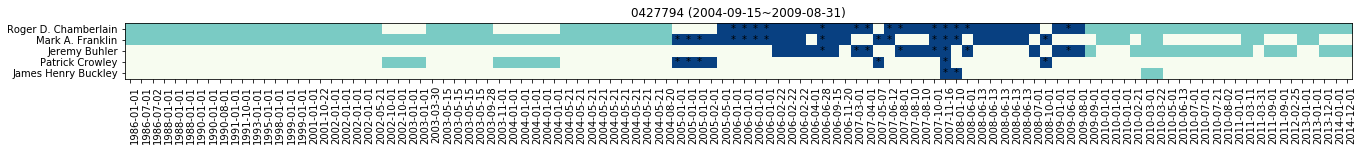

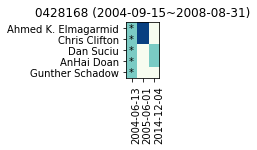

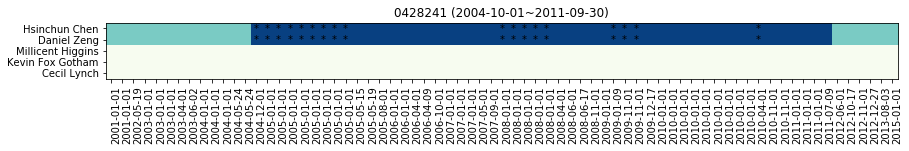

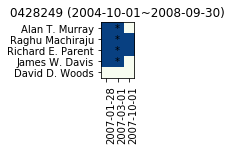

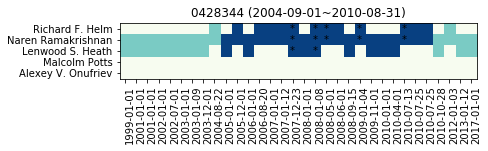

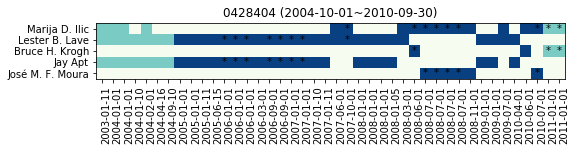

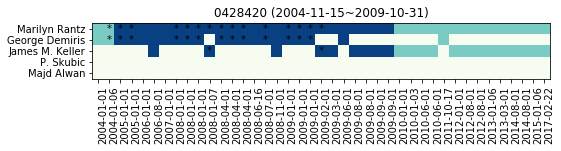

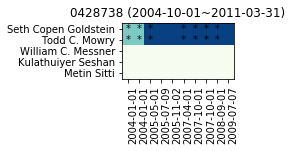

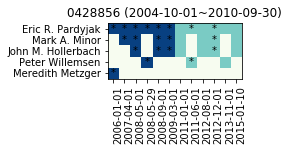

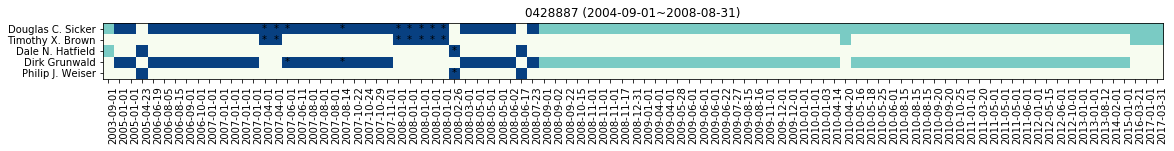

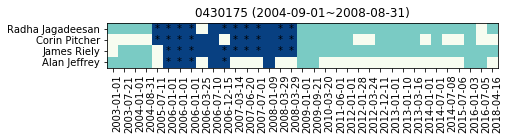

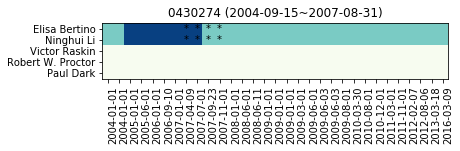

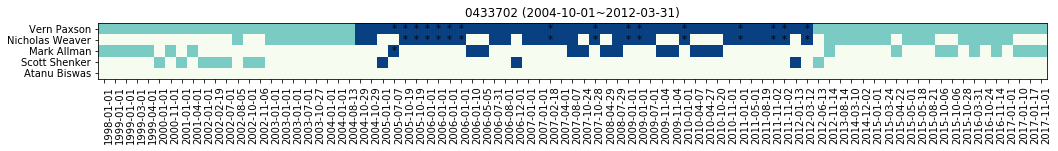

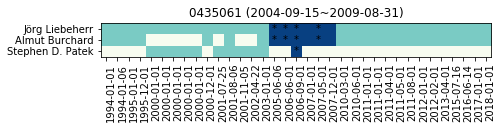

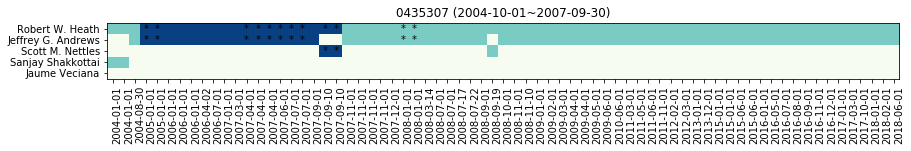

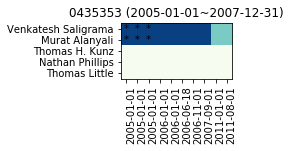

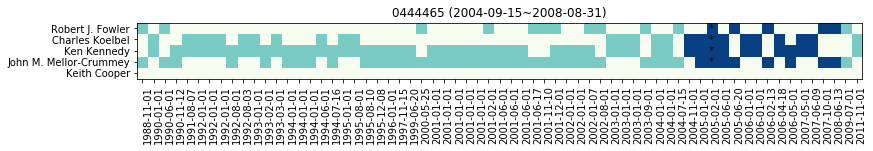

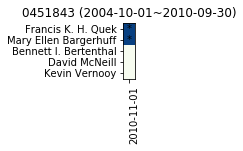

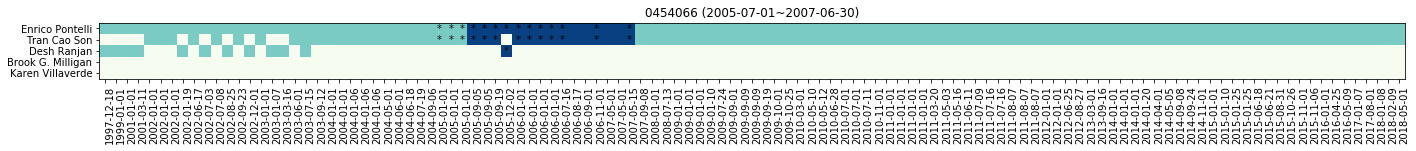

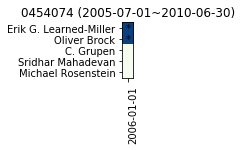

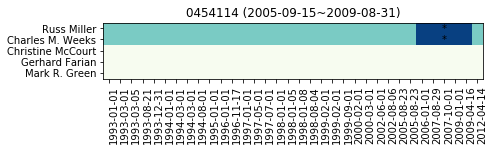

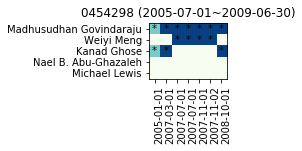

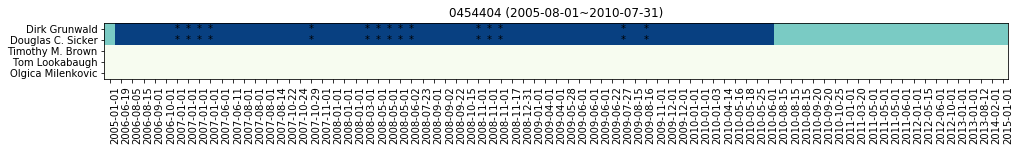

In [87]:
for pid in grant_list:
    plot_coauthor_heatmap_paper(pid)

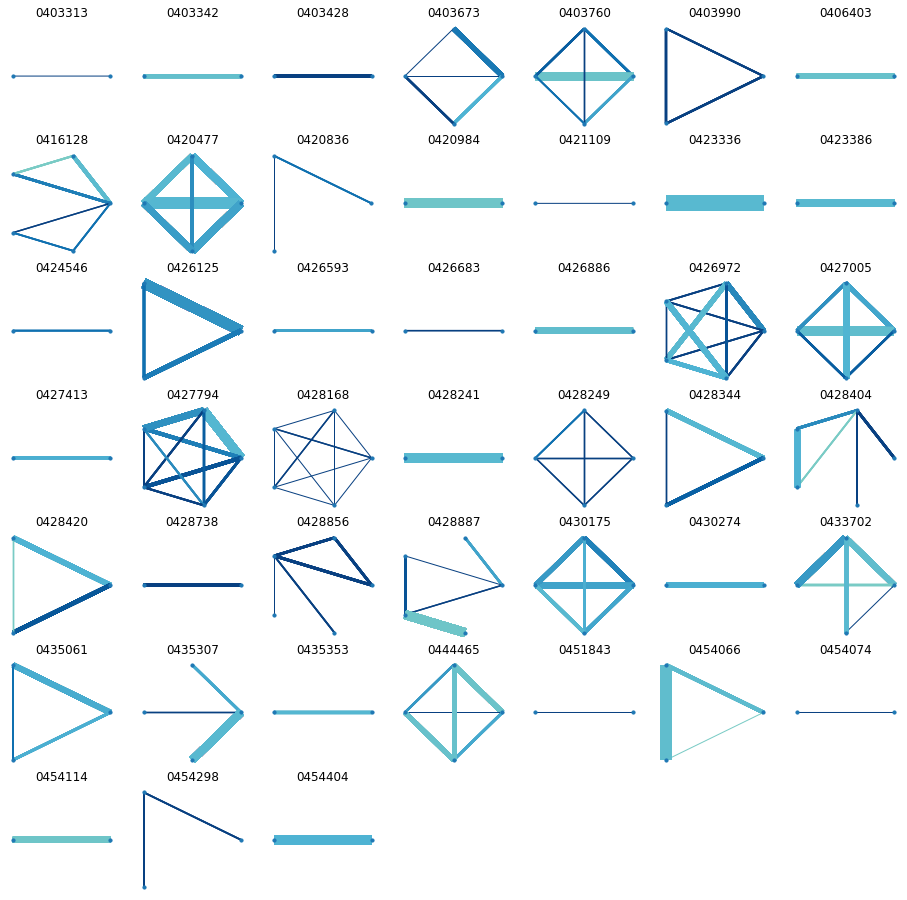

In [9]:
dim = 7
fig = plt.figure(figsize=(16,16))
gidx = 0
for grant_id in grant_list:
    _,_,_,G = core.coworknet.get_grant_coworknet_pis(grant_id)
    if len(G.edges) == 0:
        continue
#     print(G.edges.data())
    colors = []
    weight = []
    for u,v,data in G.edges.data():
#         print(G[u][v])
        types = [v["grant"] for v in G[u][v].values()]
        weight.append(np.sqrt(len(G[u][v])))
        colors.append(plt.cm.get_cmap("GnBu", 100)(150-int(100*(types.count("other")/len(types)))))
    fig.add_subplot(dim,dim,1+gidx).set_title(grant_id)
    pos = nx.circular_layout(G)
    nx.draw(G, pos, node_size = 10, edge_color=colors, width=weight)
    gidx += 1
#     if gidx >= dim*dim:
#         break

In [10]:
data = {}
years = [2009]
for y in years:
    data.update(core.nsf_utils.load_numpub_data(y))
data = {k:v for k, v in data.items() if v["type"] in grant_type}
for y in years:
    print("[{}]".format(y))
    print("Total number of grants", len([v for v in data.values() if v["year"] == y]))
    for code, desc in div_type.items():
        print(desc, len([v for v in data.values() if v["org"] == code and v["year"] == y]))

[2009]
Total number of grants 14758
Division of Computer and Network Systems (CNS) 733
Division of Computing and Communication Foundations (CCF) 535
Division of Information and Intelligent Systems (IIS) 627
Office of Advanced Cyberinfrastructure (OAC) 193


Counter({1: 1258, 2: 457, 3: 174, 5: 93, 4: 83, 6: 15, 7: 4, 8: 2, 0: 2})


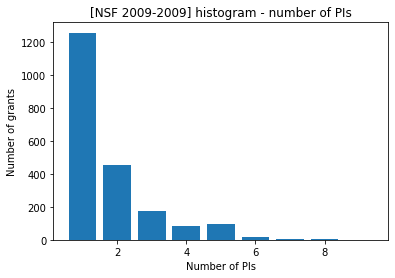

In [21]:
histogram_num_pis(data, years, div_type.keys())